# Optimal control for SIR

In [332]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, widgets
import matplotlib.dates as dates
from scipy.integrate import solve_ivp, solve_bvp
from IPython.display import Image
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)

## Optimizing for final death toll and square integral of control

In [337]:
# Tune these
c1 = 1.e4
c2 = 1.

beta = 0.5
gamma = 0.05
qmax = 1.0

du = np.zeros(2)
dlam = np.zeros(2)


def f(t, u, q):
    if t>100: q=0.
    du[0] = -(1.-q)*beta*u[1]*u[0]
    du[1] =  (1.-q)*beta*u[1]*u[0] - gamma*u[1]
    return du

def g(t, lam, u, q):
    dlam[0] = (lam[0]-lam[1])*(1-q)*beta*u[1]
    dlam[1] = (lam[0]-lam[1])*(1-q)*beta*u[0] + lam[1]*gamma
    return dlam

T = 300  # Final time
N = 1000
dt = T/N
tt = np.linspace(0,T,N+1)
uu = np.zeros((2,N+1))
lamda = np.zeros((2,N+1))
qq = np.zeros(N+1)

# Initial values
I0 = 1.e-2
u = np.array([1-I0, I0])
lamda[0,:] = -c1
uu[:,0] = u

controls = []
objectives = []

for iter in range(100):
    u = uu[:,0]
    qq = np.maximum(0,np.minimum(qmax,(lamda[1,:]-lamda[0,:])*beta*uu[1,:]*uu[0,:]/c2))
    for i, t in enumerate(tt[:-1]):
        u = u + dt*f(t,u,qq[i])
        uu[:,i+1] = u

    qq = np.maximum(0,np.minimum(qmax,(lamda[1,:]-lamda[0,:])*beta*uu[1,:]*uu[0,:]/c2))
    
    lam = np.array([-c1,0.])
    for i, t in reversed(list(enumerate(tt[1:]))):
        lam = lam - dt*g(t,lam,uu[:,i+1].squeeze(),qq[i+1])
        lamda[:,i] = lam
        
    controls.append(qq)
    objectives.append(c1*(1-S[-1])+c2*np.sum(qq**2))
    
S = uu[0,:]
I = uu[1,:]
R = 1 - S - I
print(c1*(1-S[-1])+c2*np.sum(qq**2))

10049.222499519383


In [338]:
def plot_control(i):       
    plt.plot(controls[i])
    plt.title(str(objectives[i]))

interact(plot_control,i=widgets.IntSlider(min=0,max=len(controls)-1))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_control(i)>

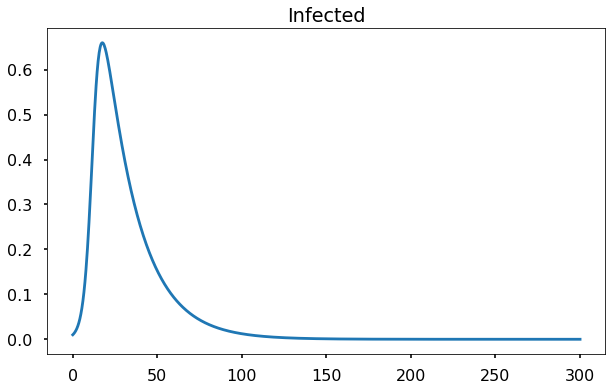

In [339]:
plt.plot(tt,uu[1,:]);
plt.title('Infected');

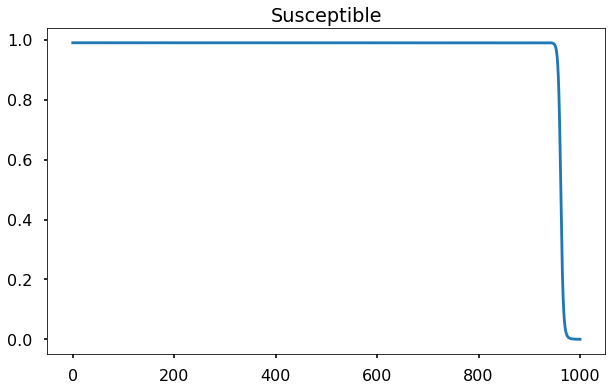

In [69]:
plt.plot(tt,uu[0,:])
plt.title('Susceptible');

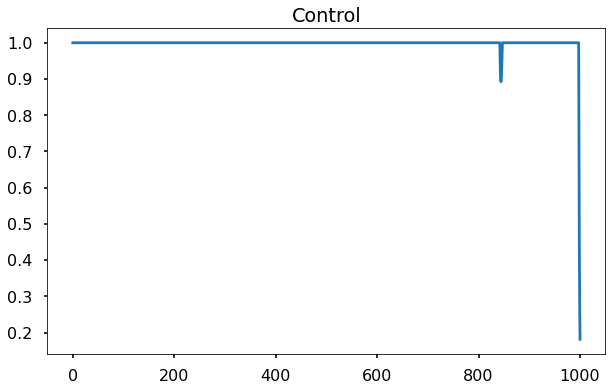

In [70]:
plt.plot(tt,qq)
plt.title('Control');

## Optimizing also for hospital capacity

In [135]:
# Tune these
c1 = 0.    # Cost of population that got infected
c2 = 0.1    # Cost of control
c3 = 10.    # Cost of going over hostpital capacity
Imax = 0.1   # Hospital capacity

beta = 0.25
gamma = 0.05
qmax = 1.0

du = np.zeros(2)
dlam = np.zeros(2)


def f(t, u, q):
    du[0] = -(1.-q)*beta*u[1]*u[0]
    du[1] =  (1.-q)*beta*u[1]*u[0] - gamma*u[1]
    return du

def g(t, lam, u, q):
    if u[1]>=Imax: alpha = 1.
    else: alpha = 0.
    dlam[0] = (lam[0]-lam[1])*(1-q)*beta*u[1]
    dlam[1] = (lam[0]-lam[1])*(1-q)*beta*u[0] + lam[1]*gamma - c3*alpha
    return dlam

T = 1000  # Final time
N = 10000
dt = T/N
tt = np.linspace(0,T,N+1)
uu = np.zeros((2,N+1))
lamda = np.zeros((2,N+1))
qq = np.ones(N+1)*0.5

# Initial values
I0 = 1.e-2
u = np.array([1-I0, I0])
lamda[0,:] = -c1
uu[:,0] = u

controls = []
objectives = []
Icurves = []

for iter in range(20):
    u = uu[:,0]
    qq = np.maximum(0,np.minimum(qmax,(lamda[1,:]-lamda[0,:])*beta*uu[1,:]*uu[0,:]/c2))
    for i, t in enumerate(tt[:-1]):
        u = u + dt*f(t,u,qq[i])
        uu[:,i+1] = u.copy()

    qq = np.maximum(0,np.minimum(qmax,(lamda[1,:]-lamda[0,:])*beta*uu[1,:]*uu[0,:]/c2))
    
    lam = np.array([-c1,0.])
    for i, t in reversed(list(enumerate(tt[1:]))):
        lam = lam - dt*g(t,lam,uu[:,i+1].squeeze(),qq[i+1])
        lamda[:,i] = lam.copy()
        
    controls.append(qq.copy())
    objectives.append(c1*(1-S[-1])+c2*dt*np.sum(qq**2)+c3*dt*np.sum(np.maximum(0,I-I0)))
    Icurves.append(uu[1,:].copy())
    
S = uu[0,:]
I = uu[1,:]
R = 1 - S - I
print(c1*(1-S[-1])+c2*dt*np.sum(qq**2)+c3*dt*np.sum(np.maximum(0,I-I0)))

186.40990286164018


In [136]:
def plot_control(i):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(Icurves[i])
    ax[1].plot(controls[i])
    ax[1].set_title(str(objectives[i]))

interact(plot_control,i=widgets.IntSlider(min=0,max=len(controls)-1))

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_control(i)>

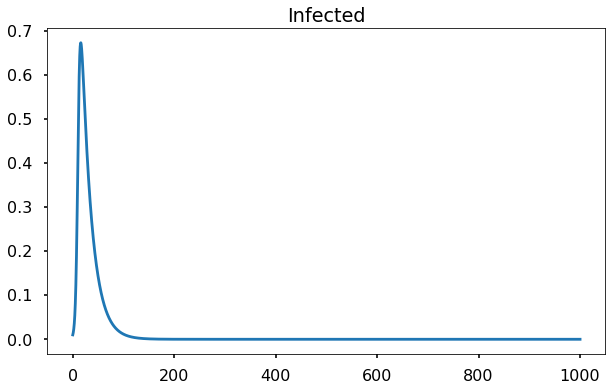

In [79]:
plt.plot(tt,uu[1,:]);
plt.title('Infected');

## Using scipy BVP solver

In [508]:
# Tune these
c1 = 1.    # Cost of population that got infected
c2 = 0.3    # Cost of control
c3 = 0.    # Cost of going over hospital capacity
Imax = 0.4   # Hospital capacity

beta = 0.5
gamma = 0.05
qmax = 1.


def rhs(t, u):
    # Variables: S, I lambda_1, lambda_2
    alpha = 1*(u[1,:]>=Imax)
    du = np.zeros((4,len(t)))

    q = (u[3,:]-u[2,:])*beta*u[1,:]*u[0,:]/c2
    q = np.maximum(0,np.minimum(qmax,q))
    q = q*(t<=200)
    du[0,:] = -(1.-q)*beta*u[1,:]*u[0,:]
    du[1,:] =  (1.-q)*beta*u[1,:]*u[0,:] - gamma*u[1]
    du[2,:] = (u[2,:]-u[3,:])*(1-q)*beta*u[1,:]
    du[3,:] = (u[2,:]-u[3,:])*(1-q)*beta*u[0,:] + u[3,:]*gamma - c3*alpha
    return du

I0 = 1.e-2 # Initial infected

def bc(ua, ub):
    return np.array([ua[0]-(1.-I0), ua[1]-I0, ub[2]+c1, ub[3]])

    
T = 400  # Final time
N = 1000
tt = np.linspace(0,T,N+1)
uu = np.zeros((4,N+1))
uu[0,:] = np.exp(-(beta-gamma)*tt/6)
uu[1,:] = 0.5*np.exp(-1.e-3*(tt-15)**2)
uu[2,:] = -c1;

result = solve_bvp(rhs, bc, tt, uu, max_nodes=200000, tol=1.e-6, verbose=2)
S = result.y[0,:]
I = result.y[1,:]
lam1 = result.y[2,:]
lam2 = result.y[3,:]
q = (lam2-lam1)*beta*S*I/c2
q = np.maximum(0,np.minimum(qmax,q))
t = result.x
print(result.message)
print(c1*(1-S[-1])+c2*sum(np.diff(t)*q[1:]))
print(S[-1])

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.12e-01       7.65e-16         1001           1238      
       2          5.81e-04       0.00e+00         2239            750      
       3          3.20e-09       0.00e+00         2989             0       
Solved in 3 iterations, number of nodes 2989. 
Maximum relative residual: 3.20e-09 
Maximum boundary residual: 0.00e+00
The algorithm converged to the desired accuracy.
1.0004048010263686
4.497967875101569e-05


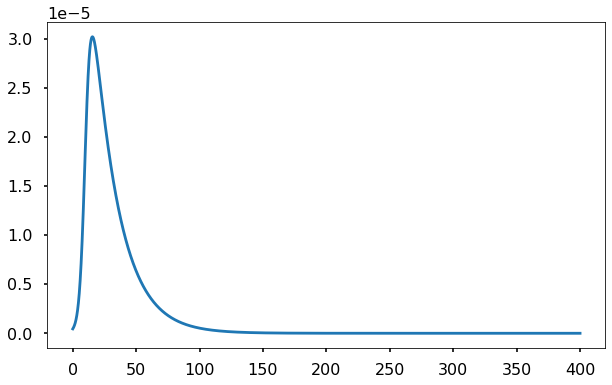

In [506]:
plt.plot(t,q);

0.6707430217440067


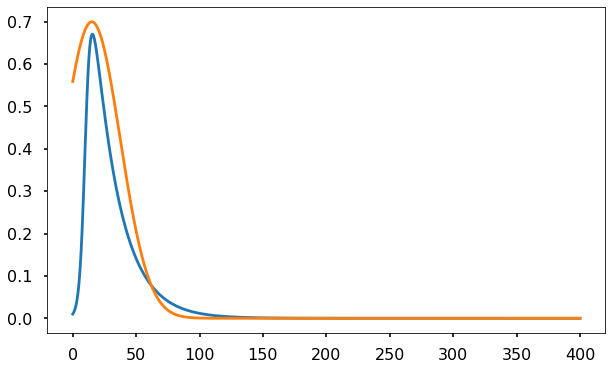

In [500]:
plt.plot(t,I);
print(np.max(I))
plt.plot(t,0.7*np.exp(-1.e-3*(t-15)**2))

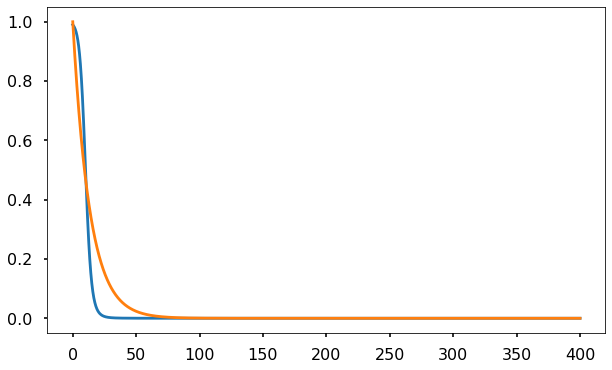

In [489]:
plt.plot(t,S)
plt.plot(t,np.exp(-(beta-gamma)*t/6))

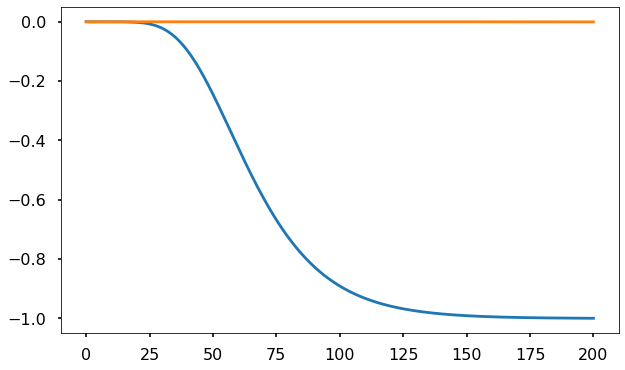

In [471]:
plt.plot(t,lam1)
plt.plot(t,lam2)

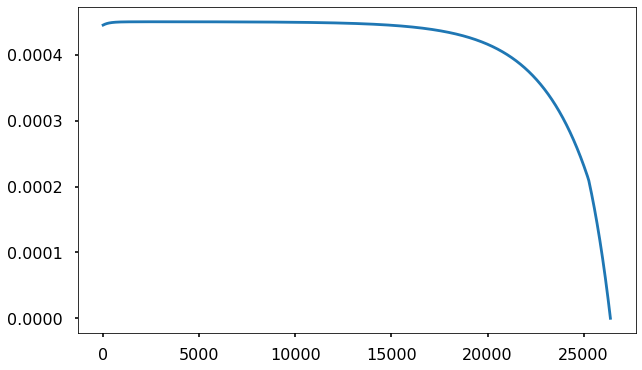

In [472]:
plt.plot(lam2)

In [222]:
S[0]

0.99

In [215]:
lam1[-1]

-0.9999999999999991

In [ ]:
qq = np.ones(N+1)*0.5

# Initial values
u = np.array([1-I0, I0])
uu[:,0] = u

controls = []
objectives = []
Icurves = []

for iter in range(20):
    u = uu[:,0]
    qq = np.maximum(0,np.minimum(qmax,(lamda[1,:]-lamda[0,:])*beta*uu[1,:]*uu[0,:]/c2))
    for i, t in enumerate(tt[:-1]):
        u = u + dt*f(t,u,qq[i])
        uu[:,i+1] = u.copy()

    qq = np.maximum(0,np.minimum(qmax,(lamda[1,:]-lamda[0,:])*beta*uu[1,:]*uu[0,:]/c2))
    
    lam = np.array([-c1,0.])
    for i, t in reversed(list(enumerate(tt[1:]))):
        lam = lam - dt*g(t,lam,uu[:,i+1].squeeze(),qq[i+1])
        lamda[:,i] = lam.copy()
        
    controls.append(qq.copy())
    objectives.append(c1*(1-S[-1])+c2*dt*np.sum(qq**2)+c3*dt*np.sum(np.maximum(0,I-I0)))
    Icurves.append(uu[1,:].copy())
    
S = uu[0,:]
I = uu[1,:]
R = 1 - S - I
print(c1*(1-S[-1])+c2*dt*np.sum(qq**2)+c3*dt*np.sum(np.maximum(0,I-I0)))